In [63]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

In [64]:
df = pd.read_csv(r"C:\Users\zacha\神州\工具\资料\data\energy_consumption\PJME_hourly.csv")

In [65]:
df.head()

,Datetime,PJME_MW
0,2002-12-31 01:00:00,26498.0
1,2002-12-31 02:00:00,25147.0
2,2002-12-31 03:00:00,24574.0
3,2002-12-31 04:00:00,24393.0
4,2002-12-31 05:00:00,24860.0


In [66]:
df.tail()

,Datetime,PJME_MW
145361,2018-01-01 20:00:00,44284.0
145362,2018-01-01 21:00:00,43751.0
145363,2018-01-01 22:00:00,42402.0
145364,2018-01-01 23:00:00,40164.0
145365,2018-01-02 00:00:00,38608.0


In [67]:
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)   op 

<Axes: title={'center': 'PJME Energy Use in g'}, xlabel='Datetime'>

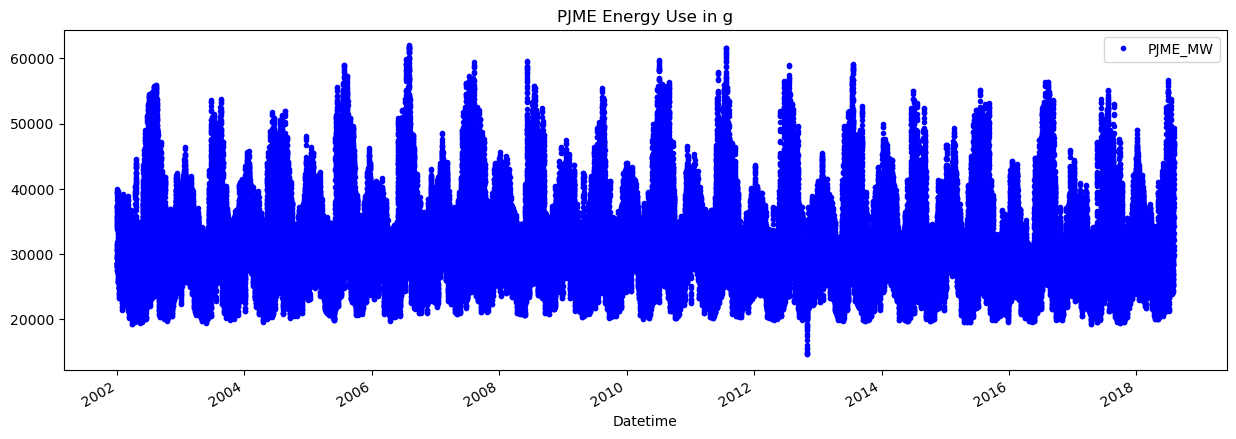

In [68]:
df.plot(style = '.',
        figsize = (15,5),
        color = 'blue',
        title = 'PJME Energy Use in g')   

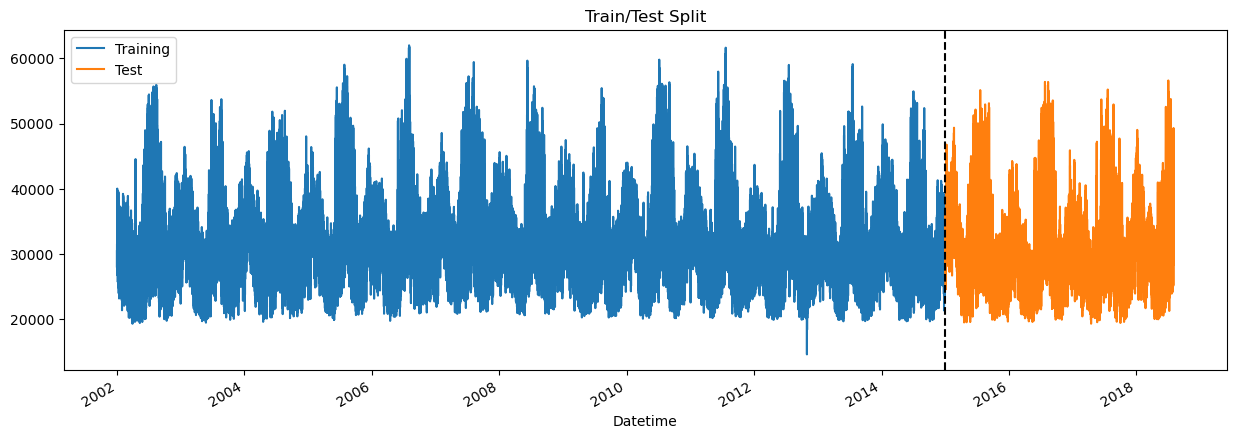

In [69]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']

fig, ax = plt.subplots(figsize = (15,5))

train.plot(ax = ax, label = 'Training', title = 'Train/Test Split')
test.plot(ax = ax, label = 'Test')

ax.axvline('01-01-2015', color = 'black', ls = '--')
ax.legend(['Training', 'Test'])

plt.show()

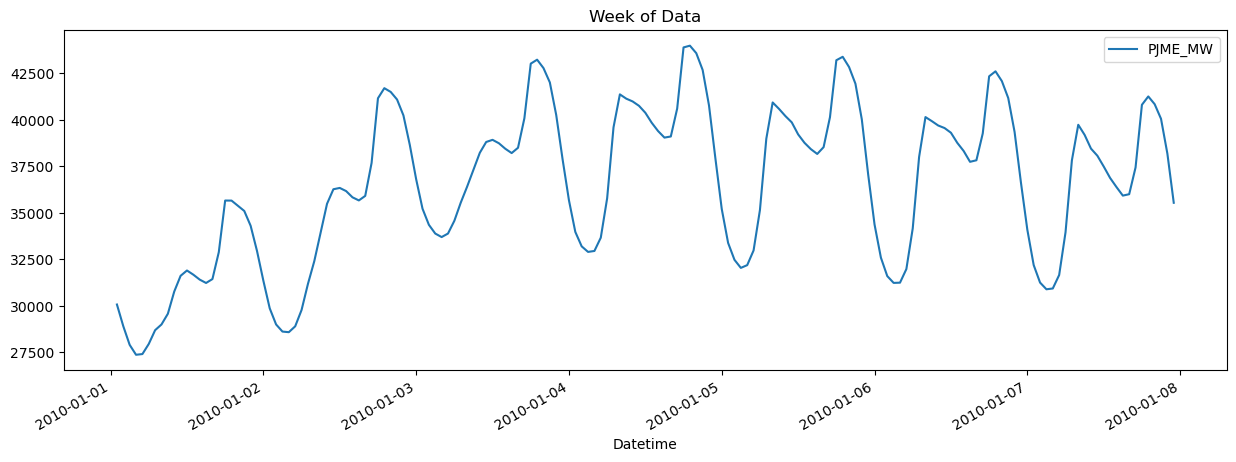

In [70]:
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')].plot(figsize = (15,5), title = 'Week of Data')
plt.show()

In [71]:
def create_features(df):
    
    df = df.copy()
    df['hour'] = df.index.hour
    df['weekday'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

In [72]:
df.head()

,PJME_MW,hour,weekday,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


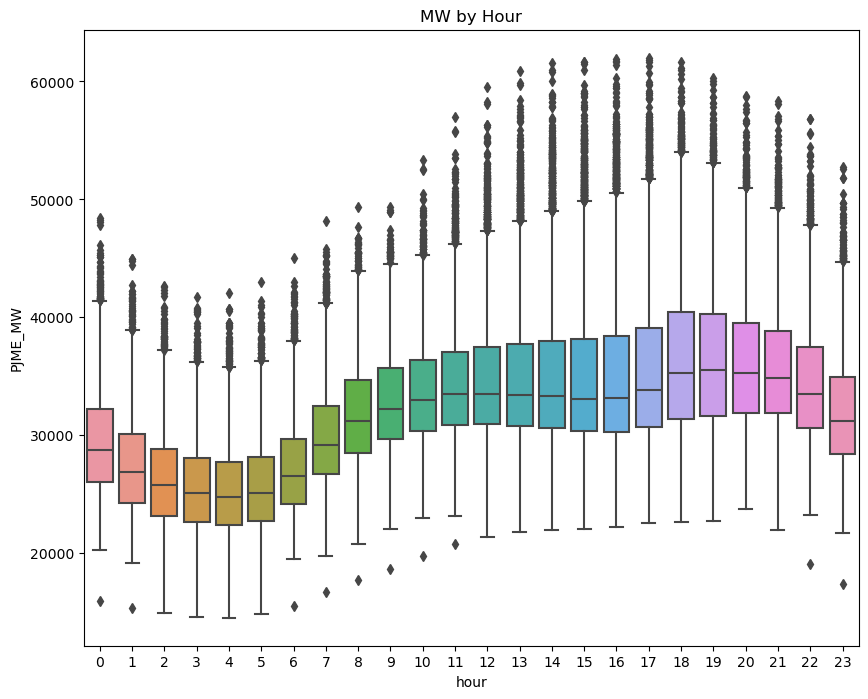

In [73]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df, x = 'hour', y = 'PJME_MW')
ax.set_title('MW by Hour')
plt.show()

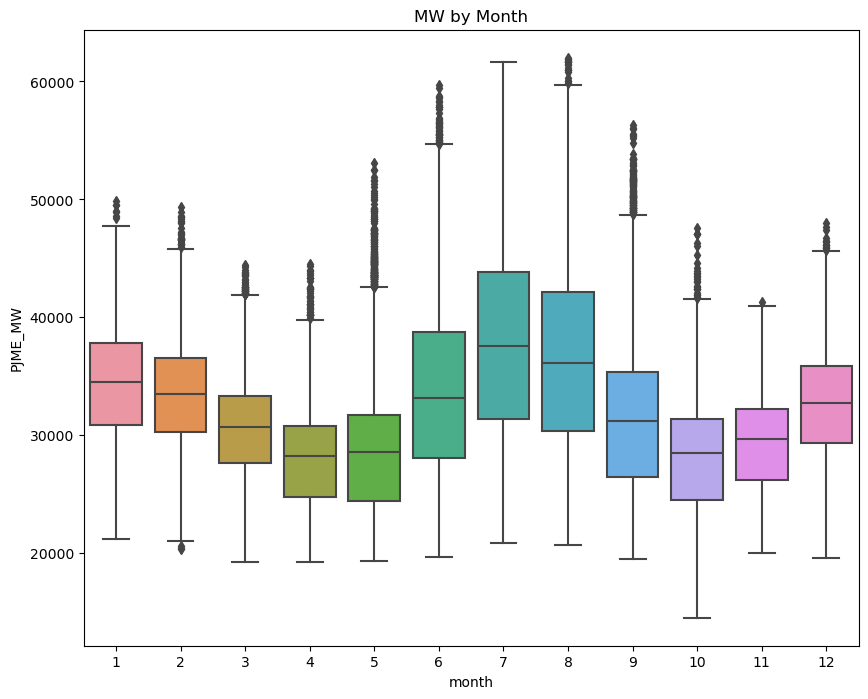

In [74]:
fig, ax = plt.subplots(figsize = (10,8))
sns.boxplot(data = df, x = 'month', y = 'PJME_MW')
ax.set_title('MW by Month')
plt.show()

In [75]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [76]:
model = xgb.XGBRegressor(n_estimators = 1000, early_stopping_rounds = 50, learning_rate = 0.01)

model.fit(x_train, y_train,
          eval_set = [(x_train, y_train), (x_test, y_test)],
          verbose = 100)

[0]	validation_0-rmse:6407.35736	validation_1-rmse:6479.81619
[100]	validation_0-rmse:3911.97994	validation_1-rmse:4312.03224
[200]	validation_0-rmse:3244.38509	validation_1-rmse:3864.56545
[300]	validation_0-rmse:2996.08999	validation_1-rmse:3748.76687
[400]	validation_0-rmse:2830.28024	validation_1-rmse:3744.93340
[416]	validation_0-rmse:2804.52217	validation_1-rmse:3748.41719


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [77]:
train = create_features(train)
test = create_features(test)

features = ['hour', 'weekday', 'quarter', 'month', 'year', 'dayofyear']
target = 'PJME_MW'

x_train = train[features]
y_train = train[target]

x_test = test[features]
y_test = test[target]

In [78]:
model.feature_importances_

array([0.46387812, 0.1620048 , 0.02888114, 0.20316096, 0.02382433,
       0.11825063], dtype=float32)

In [79]:
fi = pd.DataFrame(data = model.feature_importances_,
             index = model.feature_names_in_,
             columns = ['importance'])

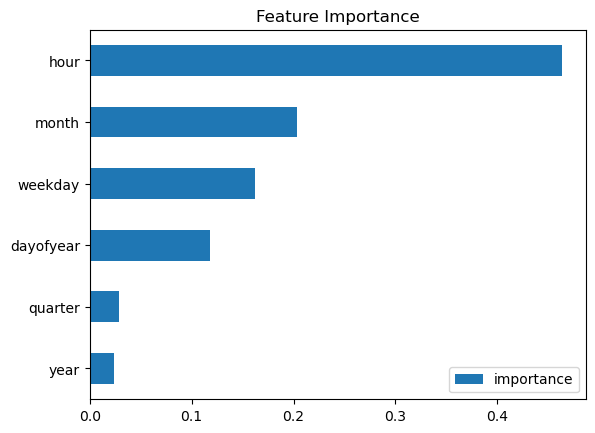

In [80]:
fi.sort_values('importance').plot(kind = 'barh', title = 'Feature Importance')
plt.show()

In [81]:
test['prediction'] = model.predict(x_test)

In [82]:
df = df.merge(test[['prediction']], how = 'left', left_index = True, right_index = True)

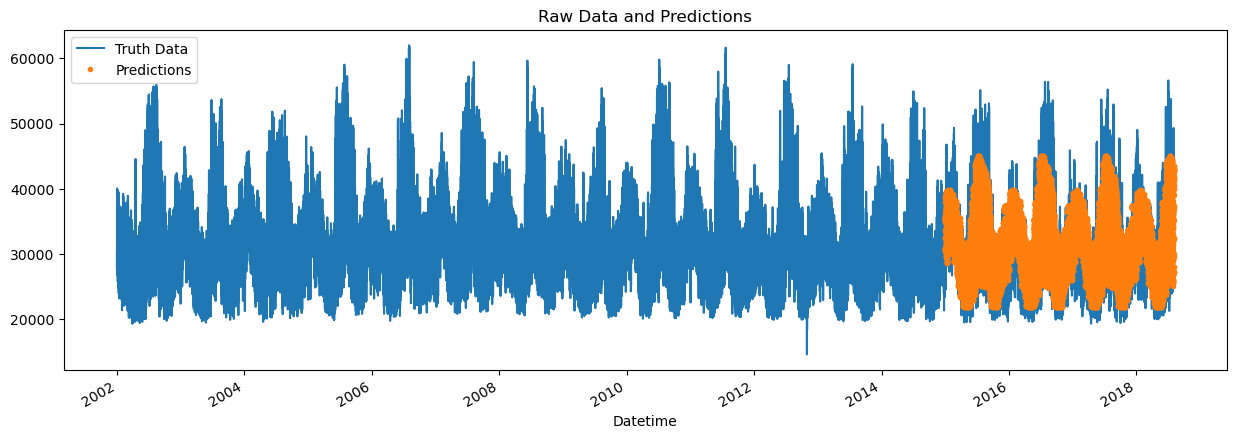

In [83]:
ax = df[['PJME_MW']].plot(figsize = (15,5))
df['prediction'].plot(ax = ax, style = '.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

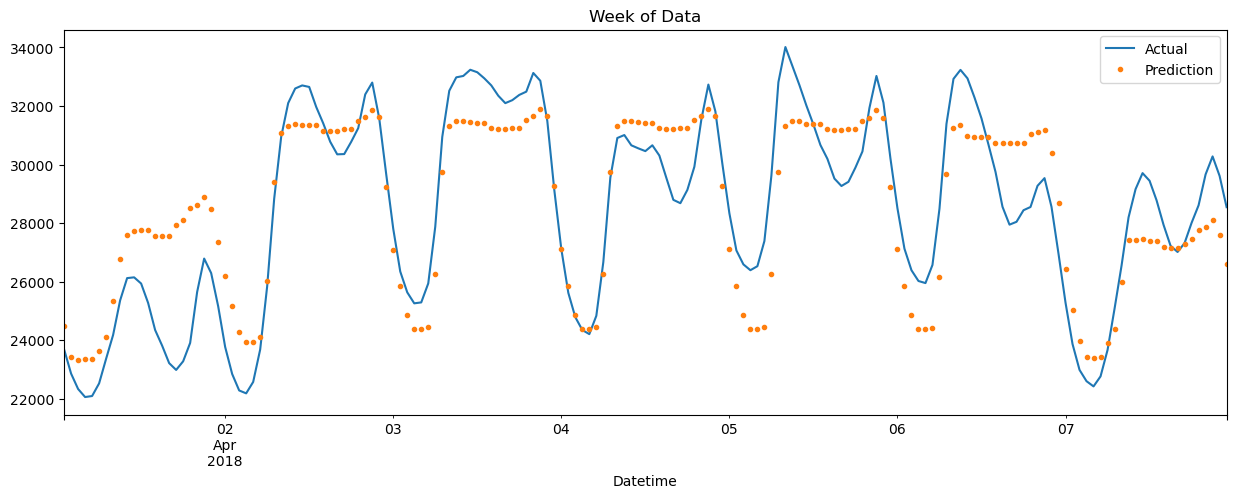

In [87]:
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize = (15,5), title = 'Week of Data')

df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style = '.')

plt.legend(['Actual', 'Prediction'])
plt.show()

In [88]:
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RSME Test Score: {score: 0.2f}')

RSME Test Score:  3741.03


In [90]:
test['error'] = np.abs(test[target] - test['prediction'])

In [91]:
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending = False).head(5)

date
2016-08-13    13829.866211
2016-08-14    13577.304362
2016-09-10    11235.855143
2016-09-09    11032.220215
2016-08-12    10667.820312
Name: error, dtype: float64

In [92]:
test.groupby(['date'])['error'].mean().sort_values(ascending = True).head(5)        youtube =

date
2016-12-30    395.436442
2017-10-24    413.885824
2016-10-27    440.053141
2016-04-04    440.223877
2017-05-02    453.738688
Name: error, dtype: float64